<font color="orange">TODO : Sommaire (w/ internal links). Intro + refs.</font>

In [333]:
import nilearn
from nilearn import input_data
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn.decomposition import DictLearning
from nilearn.regions import RegionExtractor

import sklearn
from sklearn import svm
from sklearn import model_selection

import scipy
import scipy.cluster

import bct

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

import os

In [2]:
%matplotlib inline

### <font color="red"> Save datas </font>

<font color="red"> *main_path* is the path to the folder in wich you want to save the datas. <br> Three folders will be created, one for each atlas. </font>

In [3]:
main_path = r"C:\Users\lison\Desktop\Stage"

In [4]:
harvard_path = main_path+"\\Harvard\\"
if not os.path.exists(harvard_path):
    os.makedirs(harvard_path)

In [5]:
power_path = main_path+"\\Power\\"
if not os.path.exists(power_path):
    os.makedirs(power_path)

In [6]:
dict_path = main_path+"\\DictLearn\\"
if not os.path.exists(dict_path):
    os.makedirs(dict_path)

# I - Datas

### Dataset : **COBRE**
COBRE is a dataset of IRM from 72 patients with schizophrenia and 74 healthy controls. More information about the dataset and the preprocessing 
<a href="https://figshare.com/articles/COBRE_preprocessed_with_NIAK_0_17_-_lightweight_release/4197885">here</a>. 

In [7]:
datas = datasets.fetch_cobre(n_subjects=None, verbose=1)

In [8]:
print(datas.desc_phenotypic)

{
    "ID": " Identification Number - unique for each participant (expect an integer).",
    "Current Age": "Current age of the participant (expect an integer, number of years).",
    "Gender": "sex of the participant (expect 'Male' or 'Female').", 
    "Handedness": "Hand dominance of the participant (expect 'Right', 'Left' or 'Both').",
    "Subject Type": "Diagnostic status of the participant (expect 'Control', no clinical diagnosis was made, or 'Patient', diagnosis of schizophrenia.",
    "Diagnosis": "Clinical diagnosis made for the participant, based on the Diagnostic and Statistical Manual of Mental Disorders (DSM), (expect 'None', for control participants, 290.3 or other similarly formed numbers, code for specific diagnosis as described in http://www.icd9data.com/2007/Volume1/290-319/",
    "Frames OK": "Number of time frames deemed to have an acceptable level of motion (expect an integer)",
    "FD": "Measure of average frame displacement on raw time series, as defined by Powe

### Choice of subjects

Previous results, with all subjects, weren't great, so we made a few changes in pre-processing :
- Global Signal was removed from the confounds
- Scrubbed frames were removed from time_series. To ensure there were still enought frames to compute a connectivity matrix, subjects who had less than 60 frames were removed from the study. <br>

This left us with 45 controls and 50 patients. A sample of 20 patients and 20 matched controls was then selected. Subjects were matched by age (18-53y), gender (15 males, 5 females in each group), handedness (all subject selected are right-handed), and FD Scrubbed. <br>

<table style="width:70%">
  <tr>
    <th>Status</th>
    <th>Age</th>
    <th>Gender</th>
    <th>FD Scrubbed</th>
    <th>ID</th>
  </tr>
  <tr>
    <td>Control</td>
    <td>18</td>
    <td>Male</td>
    <td>0.22657</td>
    <td>40061</td>
  </tr>
  <tr>
    <td>Patient</td>
    <td>19</td>
    <td>Male</td>
    <td>0.21575</td>
    <td>40002</td>
  </tr>
  <tr>
    <td>Control</td>
    <td>18</td>
    <td>Female</td>
    <td>0.16963</td>
    <td>40090</td>
  </tr>
   <tr>
    <td>Patient</td>
    <td>20</td>
    <td>Female</td>
    <td>0.20245</td>
    <td>40000</td>
  </tr>
   <tr>
    <td> Control </td>
    <td> 20 </td>
    <td> Male </td>
    <td>0.1579 </td>
    <td> 40113 </td>
   </tr>
   <tr>
    <td> Patient </td>
    <td> 19 </td>
    <td> Male </td>
    <td> 0.15521 </td>
    <td> 40145 </td>
   </tr>
   <tr>
    <td> Control </td>
    <td> 22 </td>
    <td> Female </td>
    <td> 0.22395 </td>
    <td> 40052 </td>
   </tr>
   <tr>
    <td> Patient </td>
    <td> 21 </td>
    <td> Female </td>
    <td> 0.28146  </td>
    <td> 40021 </td>
   </tr>
   <tr>
    <td> Control </td>
    <td> 22 </td>
    <td> Male </td>
    <td> 0.16432 </td>
    <td> 40065 </td>
   </tr>
   <tr>
    <td> Patient </td>
    <td> 22 </td>
    <td> Male  </td>
    <td> 0.14984 </td>
    <td> 40085 </td>
   </tr>
   <tr>
    <td> Control 
    <td> 22 
    <td> Male 
    <td> 0.43736
    <td> 40128
   </tr>
   <tr>
    <td> Patient
    <td> 23
    <td> Male
    <td> 0.50509
    <td> 40073
   </tr>
   <tr>
    <td> Control
    <td> 23
    <td> Male 
    <td> 0.29275 
    <td>40114 
   </tr>
   <tr>
    <td> Patient
    <td> 22
    <td> Male
    <td> 0.30721 
    <td> 40096 
   </tr>
   <tr>
    <td> Control 
    <td> 24 
    <td> Male 
    <td> 0.1538
    <td> 40091
   </tr>
   <tr>
    <td> Patient 
    <td> 25
    <td> Male 
    <td> 0.17674 
    <td> 40059 
   </tr>
   <tr>
    <td> Control 
    <td> 26
    <td> Male
    <td> 0.23106
    <td> 40104 
   </tr>
   <tr>
    <td> Patient
    <td> 25
    <td> Male
    <td> 0.25813 
    <td> 40072
   </tr>
   <tr>
    <td> Control 
    <td> 28
    <td> Female
    <td> 0.1618
    <td> 40139 
   </tr>
   <tr>
    <td> Patient
    <td> 31
    <td> Female 
    <td> 0.18381
    <td> 40032 
   </tr>
   <tr>
    <td> Control 
    <td> 33
    <td> Female
    <td> 0.29359 
    <td> 40107
   </tr>
   <tr>
    <td> Patient
    <td> 32
    <td> Female 
    <td> 0.32061
    <td> 40012 
   </tr>
   <tr>
    <td> Control 
    <td> 33
    <td> Male
    <td> 0.17101
    <td> 40067 
   </tr>
   <tr>
    <td> Patient
    <td> 33 
    <td> Male 
    <td> 0.23537 
    <td> 40025 
   </tr>
   <tr>
    <td> Control
    <td> 35
    <td> Male
    <td> 0.22583 
    <td> 40124 
   </tr>
   <tr>
    <td> Patient
    <td> 35
    <td> Male 
    <td> 0.28621
    <td> 40098 
   </tr>
   <tr>
    <td> Control
    <td> 38
    <td> Male
    <td> 0.20795
    <td> 40043 
   </tr>
   <tr>
    <td> Patient
    <td> 38
    <td> Male 
    <td> 0.24305 
    <td> 40099 
   </tr>
   <tr>
    <td> Control
    <td> 39
    <td> Male 
    <td> 0.23899
    <td> 40146 
   </tr>
   <tr>
    <td> Patient
    <td> 40 
    <td> Male 
    <td> 0.17775
    <td> 40103 
   </tr>
   <tr>
    <td> Control
    <td> 40
    <td> Female
    <td> 0.22769 
    <td> 40102 
   </tr>
   <tr>
    <td> Patient 
    <td> 40 
    <td> Female 
    <td> 0.33002 
    <td> 40042 
   </tr>
   <tr>
    <td> Control 
    <td> 47
    <td> Male
    <td> 0.19725 
    <td> 40018
   </tr>
   <tr>
    <td> Patient 
    <td> 46 
    <td> Male
    <td> 0.16822
    <td> 40106 
   </tr>
   <tr>
    <td> Control 
    <td> 48
    <td> Male
    <td> 0.2608
    <td> 40125
   </tr>
   <tr>
    <td> Patient 
    <td> 49 
    <td> Male 
    <td> 0.28436 
    <td> 40092 
   </tr>
   <tr>
    <td> Control
    <td> 50 
    <td> Male 
    <td> 0.21444
    <td> 40062
   </tr>
   <tr>
    <td> Patient    
    <td> 50 
    <td> Male
    <td> 0.31121 
    <td> 40101 
   </tr>
   <tr>
    <td> Control
    <td> 52 
    <td> Male
    <td> 0.28347 
    <td> 40054 
   </tr>
   <tr>
    <td> Patient
    <td> 53 
    <td> Male
    <td> 0.20964
    <td> 40006 
   </tr>
</table> 

In [9]:
# IDs of selected patients (ID from the study)
ID_control = [40061, 40113, 40065, 40114, 40067, 40062, 40054, 40128, 40104, 40091,
              40124, 40043, 40146, 40018, 40125, 40090, 40052, 40139, 40107, 40102]
ID_patient = [40002, 40145, 40085, 40096, 40025, 40101, 40006, 40073, 40072, 40059,
              40098, 40099, 40103, 40106, 40092, 40000, 40021, 40032, 40012, 40042]

In [10]:
# more useful id: indice of the list of subjects
id_control = []
id_patient = []
for i in range(145): 
    id_i = datas.phenotypic[i][0]
    if id_i in ID_control: # Not that long to test since it's len 20
        id_control.append(i)
    elif id_i in ID_patient: # Not that long to test since it's len 20
        id_patient.append(i)

<font color="red"> If you want to use all subjects instead of matched ones, de-comment the code below. <br>
These are the id for every control and patient you can compute matrices from.
Other subjects in the study don't have enought non-scrubbed frames. </font>

In [120]:
# id_control = [0, 1, 6, 14, 15, 16, 21, 22, 26, 28, 35, 36, 43, 46, 54, 57, 63, 64, 72,
              # 73, 76, 77, 78, 80, 83, 84, 85, 94, 95, 98, 99, 100, 103, 104, 105, 109,
              # 110, 111, 116, 122, 128, 129, 131, 136, 144]
# id_patient = [2, 3, 4, 5, 7, 8, 9, 11, 12, 17, 18, 19, 24, 25, 32, 33, 39, 51, 61, 62,
              # 65, 74, 75, 82, 86, 87, 88, 89, 90, 93, 96, 97, 101, 102, 107, 112, 113, 
              # 114, 115, 118, 120, 125, 127, 130, 132, 133, 134, 135, 138, 140]

In [279]:
id_subjects = np.concatenate((id_control, id_patient))
n_control = len(id_control)
n_patient = len(id_patient)
n_subject = n_control + n_patient

### Matched subjects: Datas phenotypics

#### List phenotypics

In [12]:
list_pheno = []
for i in id_subjects:
    pheno = datas.phenotypic[i]
    dict_pheno = {}
    dict_pheno["ID"] = pheno[0]
    dict_pheno["Age"] = pheno[1]
    dict_pheno["Gender"] = str(pheno[2])[2:][:-1]
    dict_pheno["Status"] = str(pheno[4])[2:][:-1]
    dict_pheno["FD"] = pheno[8]
    list_pheno.append(dict_pheno)

#### Gender

There are 5 women and 15 men in each group.

#### Age

In [13]:
ages_subjects = [datas.phenotypic[i][1] for i in id_subjects]    

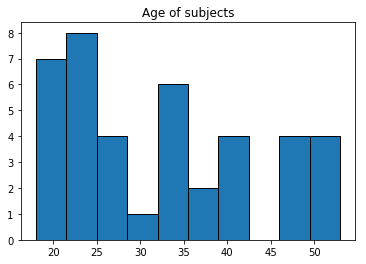

In [14]:
plt.hist(ages_subjects, bins=10, edgecolor="black")
plt.title("Age of subjects")

#### Handedness

All subjects are right-handed.

# II - Atlas and preprocessing

Different atlas were used : 
<a url="http://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html">
Harvard-Oxford </a>;
<a url="http://nilearn.github.io/modules/generated/nilearn.datasets.fetch_coords_power_2011.html"> 
Power Atlas </a>; 
<a url="http://nilearn.github.io/modules/generated/nilearn.decomposition.DictLearning.html#nilearn.decomposition.DictLearning">
Dictionnary learning </a>.


(Communities were also used (`bct.modularity_und`) with Poxer Atlas to reduce the size of the datas.
However, communities are not computed here because there was no significant progress compared to other atlas.)

## Preprocessing

We remove Global Signal and scrubbed frames.

In [15]:
control_confs = []
control_scrub = []

for i in id_control:
    # Fetch datas
    confounds_file = datas.confounds[i]
    conf = np.genfromtxt(confounds_file)
    # Remove Global Signal
    conf = np.delete(conf, obj = 16, axis = 1) 
    # Remove labels
    conf = np.delete(conf, obj = 0, axis = 0) 
    # Scrubbed frames
    scrub = [i for i in range(150) if conf[i,7]==1] 
    #Remove Scrub 
    conf = np.delete(conf, obj = 7, axis = 1)  
    
    control_confs.append(conf)
    control_scrub.append(scrub)

    
patient_confs = []
patient_scrub = []

for i in id_patient:
    # Fetch datas
    confounds_file = datas.confounds[i]
    conf = np.genfromtxt(confounds_file)
    # Remove Global Signal
    conf = np.delete(conf, obj = 16, axis = 1) 
    # Remove labels
    conf = np.delete(conf, obj = 0, axis = 0) 
    # Scrubbed frames
    scrub = [i for i in range(150) if conf[i,7]==1] 
    #Remove Scrub 
    conf = np.delete(conf, obj = 7, axis = 1)  
    
    patient_confs.append(conf)
    patient_scrub.append(scrub)

## Atlas

### Harvard Oxford
Atlas of 48 regions.

In [16]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
n_regions_harvard = len(labels)-1

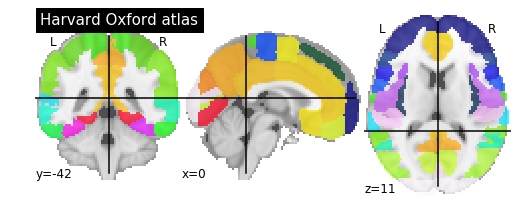

In [17]:
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

In [18]:
harvard_masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename,
                                          standardize=True,
                                          detrend=True,
                                          t_r=2,
                                          high_pass=0.01,
                                          smoothing_fwhm=4, 
                                          memory='nilearn_cache',
                                          verbose=0)

### Power Atlas
Atlas of 264 spheres.

In [19]:
power = datasets.fetch_coords_power_2011()
coords_power = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T # Coords of spheres
n_coords_power = len(coords_power)

c:\program files (x86)\pyzo2015a\lib\site-packages\nilearn\plotting\glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \


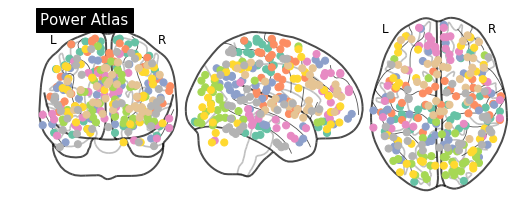

In [20]:
# Plotting the Atlas
plotting.plot_connectome(np.zeros((n_coords_power, n_coords_power)), coords_power, title="Power Atlas")
# (The color is just color mode by default ; we could have all nodes
# of the same color, I just find this clearer.)

In [21]:
power_masker = input_data.NiftiSpheresMasker(seeds=coords_power, # Coords of atlas
                                               smoothing_fwhm=4, 
                                               radius=5., # Radius of the sphere
                                               detrend=True, 
                                               standardize=True, # Standardize datas
                                               high_pass=0.01,
                                               t_r=2,
                                               verbose=0)

### Dictionnary Learning
Learns an atlas from the datas. <font color="red"> Number of components can be changed. </font>

In [182]:
n_comp = 10 # Number of components - set to 10 now but can be changed.

In [183]:
# Initialize DictLearning object
dict_learn = DictLearning(n_components=n_comp, 
                          smoothing_fwhm=4., detrend=True, 
                          standardize=True, t_r=2., high_pass=0.01,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0, verbose=0)

In [184]:
# Fit to the data
dict_learn.fit(np.asarray(datas.func)[id_subjects])
# Resting state networks/maps
components_img = dict_learn.masker_.inverse_transform(dict_learn.components_)

c:\program files (x86)\pyzo2015a\lib\site-packages\matplotlib\contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


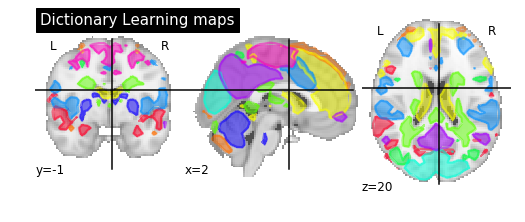

In [185]:
# Visualization of resting state networks
# Show networks using plotting utilities
plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

In [186]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
dict_extractor = RegionExtractor(components_img, threshold=0.5,
                                thresholding_strategy='ratio_n_voxels',
                                extractor='local_regions',
                                standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
dict_extractor.fit()

RegionExtractor(detrend=False, extractor='local_regions', high_pass=None,
        low_pass=None,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x000000000F28CA90>,
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        min_region_size=1350, standardize=True, t_r=None, threshold=0.5,
        thresholding_strategy='ratio_n_voxels', verbose=0)

In [187]:
# Extracted regions are stored in regions_img_
regions_extracted_img = dict_extractor.regions_img_
# Each region index is stored in index_
regions_index = dict_extractor.index_
# Total number of regions extracted
n_regions_dict = regions_extracted_img.shape[-1]

c:\program files (x86)\pyzo2015a\lib\site-packages\matplotlib\contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
c:\program files (x86)\pyzo2015a\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


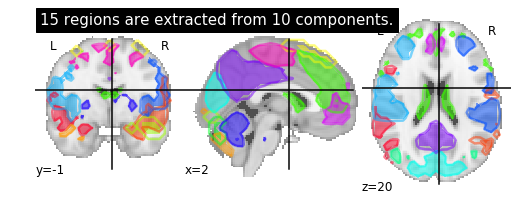

In [188]:
# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         % (n_regions_dict, n_comp))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

# III - Useful functions

## Parcellation

In [181]:
def parcellation(atlas_masker, id_list, confs, scrubs):
    """
    Computes the time_series for the subjects of in datas.func(id_list).
    ---
    Params:
    atlas_masker: masker to use for the parcellation (NiftiMasker)
    id_list: id of subjects to consider (int list)
    confs: list of confounds for each subject (slist)
    scrubs: list of scrubbed frames for each subject (list)
    ---
    Returns:
    l: list of times_series computed (list)
    ---
    Note that confs and scrubs have only been computed for the 40 matched subjects.
    Subjects 34 and 41 (from the complete set of subjects) have less axis in their confounds
    so the computation from them might return an error.
    """
    l = []
    for (i, conf, scrub) in zip(id_list, confs, scrubs):
        fmri_filenames = datas.func[i]
        if (atlas_masker == dict_extractor):
            time_series = dict_extractor.transform(fmri_filenames, confounds=conf)
        else:
            time_series = atlas_masker.fit_transform(fmri_filenames, conf)
        time_series = np.delete(time_series, obj = scrub, axis = 0) #Remove Scrub
        l.append(time_series)
    return(l)

## Matrices

In [30]:
def connectivity_matrices(time_series, connectivity_measure):
    """
    Computes the connectivity matrices from time_series.
    ---
    Params:
    time_series (list): Time_series from which to compute the connectivity matrices
    connectivity_measure (string): Connectivity measure to use.
                                   Options are: "correlation", "partial correlation",
                                                "covariance", "precision", "tangent"
    ---
    Returns:
    A list of connectivity matrices.
    """
    c = ConnectivityMeasure(kind=connectivity_measure)
    return(c.fit_transform(time_series))

## Measures on matrices

In [31]:
def list_clustering_coef (M, wei):
    """
    Computes a list of clustering coefficients.
    ---
    Params:
    M (list of list or numpy.ndarray): list of matrices.
       must be of form M[k][s] = Matrix of subject s for threshold k.
    wei (bool): Matrices weighted or binary
    ---
    Returns:
    l_clus (list): l[k][s][i] = coef for node i, subject s, threshold k.
    l_mean_clu (list): l[k] = mean coef for threshold k.
    l_error (list): l[k] = error for threshold k (computed on subjects only)
    
    """
    l_clus = []
    l_mean_clu = []
    l_error = []
    
    for Mk in M:
        l_clu_K = []
        a = []
        
        for m in Mk:
            if wei:
                c = bct.clustering_coef_wu(m)
            else:
                c = bct.clustering_coef_bu(m)
            l_clu_K.append(c)
            a.append(np.mean(c))
            
        l_clus.append(l_clu_K)
        l_mean_clu.append(np.mean(l_clu_K)) # Mean on subjects and nodes
        l_error.append(np.std(a)/np.sqrt(len(Mk)))

    return(l_clus, l_mean_clu, l_error)

In [32]:
def list_charpath_eff (M, wei):
    """
    Computes characteristic path and global efficiency
    for a list of matrices.
    ---
    Params:
    M (list or numpy.ndarray): list of matrices.
        M[k][s] = Matrix of subject s for threshold k.
    wei (bool): Matrices weighted or binary (default is True) 
    ---
    Returns:
    l_path : l[k][i] = charpath for threshold k, subject i
    l_eff_wei : l[k][i] = eff for threshold k, subject i 
    ---
    Note that for weighted matrices, characteritic path is
    computed from weights and not number of edges. 
    """
    l_path = []
    l_eff = []
    for MK in M:
        l_path_K = []
        l_eff_K = []
        for m in MK:
            
            if wei:
                # We need to get a connection_lenght matrix first:
                mt = np.reciprocal(m, dtype='float') # We want to be sure dtype==float
                                                     # because np.reciprocal[0.] = [inf] but 
                                                     # np.reciprocal[0] = -2147483648 (for np.int32).
                                                     # (However, 'inf' means we can't compute radius 
                                                     #  nor diameter - we only get 'nan'.)
                # And then a distance matrix:
                dm_wei, dm_edges = bct.distance_wei(mt)
                # Finally we have it!
                c = bct.charpath(dm_wei)
    
            else:
                # We need first the distance matrix:
                dm = bct.distance_bin(m)
                # Now we can compute charpath
                c = bct.charpath(dm)
            
            l_path_K.append(c[0])
            l_eff_K.append(c[1])
                
        l_path.append(l_path_K)
        l_eff.append(l_eff_K)
    return(l_path, l_eff)

In [306]:
def list_degrees (M):
    """
    Computes a list of degrees.
    ---
    Params:
    M (list of list or numpy.ndarray): list of matrices.
       must be of form M[k][s] = Matrix of subject s for threshold k.
    ---
    Returns:
    l_deg (list): l[k][s][i] = degree for node i, subject s, threshold k.
    l_mean (list): l[k][i] = mean degree for threshold k, node i (mean on subjects). 
    """
    l_deg = []
    l_mean = []
    
    for Mk in M:
        l_deg_K = []
        
        for m in Mk:
            l_deg_K.append(bct.degrees_und(m))
        
        l_deg.append(l_deg_K)
        l_mean.append(np.mean(l_deg_K, axis=0))
        
    return(l_deg, l_mean)

## Visualisation

In [33]:
def plot_matrices(mat, path=None, title="", labels=None, show=True):
    """
    Visualisation of matrices. Can plot figure or save them.
    ---
    Params:
    mat (np.ndarray or list of list): Matrice to plot 
    path (string): Where to save the figure. Default=None (won't save the figure).
    title (string): Title of the figure. Default="".
    labels: legend. Default=None.
    show (boolean): Show the figure. Default=True.
    ---
    Returns:
    Plot the figure or save it.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(mat, interpolation="nearest", cmap="RdBu_r")
    plt.colorbar()
    plt.title(title)
    if labels is not None:   
        x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
        plt.gca().yaxis.tick_right()
    if path is not None:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close() 

In [34]:
def plot_errorbar_K_list(K_list, control_means, control_errors,
                         patient_means, patient_errors,
                         ylabel, title, show=True, path=None):
    """
    Plot the errorbar for two lists of measure (controls and patients).
    ---
    Params:
    K_list (list)
    control_means (list): mean on all control of the measure to plot
    control_errors (list): control errorbars    
    patient_means (list): mean on all patient of the measure to plot
    patient_errors (list): patient errorbars
    ylabel (str): label for the y axis
    title (str): title of the figure
    show (bool): image shown or not (default=True)
    path (str or None): if not None, figure is saved at path.
    ---
    Show or save the figure.
    """
    plt.errorbar(x=K_list, y=control_means, yerr=control_errors, marker='+', label="Control")
    plt.errorbar(x=K_list, y=patient_means, yerr=patient_errors, marker='+', label="Patient")
    plt.xlabel("K (% edges conserved)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if path is not None:
        plt.savefig(path)
    if not show:
        plt.close()

## Statistics

In [35]:
def plot_t_test(c_list, p_list, title, K_list):
    """
    Plot p-values for a list of control and patient measures.
    ---
    Params:
    c_list: list of values for control
    p_list: list of values for patient
    title (str): title of the figure
    K_list (list): list of the x axis of the plot
    ---
    Plot p-values for k in K_list;
    """
    t_test_p = []
    for c, p in zip(c_list, p_list):
        t_test_p.append(scipy.stats.ttest_ind(c, p, equal_var=False)[1])
    plt.scatter(K_list, t_test_p, marker='+', color="red")
    plt.xlabel("Threshold K")
    plt.ylabel("p_value")
    plt.title(title)
    plt.axhline(0.05, color="green")
    plt.axhline(0.01, color="green")
    plt.axhline(0.005, color="green")

## Classification

In [331]:
def fun_svm(control, patient, svm_name):
    """
    Test a SVM (SVM, LogisticRegression...) on some datas for control and patient
    ---
    Params:
    control (list): list of datas for control
    patient (list): list of datas for patient (must be same length as control)
    svm_name: the classifier to use
    ---
    Prints the scrore (accuracy)
    """
    n = len(control)
    Y = [0 if i < n else 1 for i in range(2*n)] #Patient: 1 - Control: 0
    X = np.concatenate((control, patient))
    cv_scores = model_selection.cross_val_score(svm_name, X, Y, cv=8, scoring='accuracy')
    print('Score: %1.2f +- %1.2f' % (cv_scores.mean(), cv_scores.std()))

In [37]:
def dendrogram(d, l=None):
    """
    Plot a dendrogramm from a distance matrix
    --- 
    Params:
    d (matrix): distance matrix
    l (list): labels (default is None)
    """
    z = scipy.spatial.distance.squareform(d)
    z = scipy.cluster.hierarchy.linkage(z)
    scipy.cluster.hierarchy.dendrogram(z, labels=l, orientation='right')  
    plt.setp(plt.gca().get_ymajorticklabels(), size=12) 
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.show()

## General

In [138]:
def general_clustering_coef (MC, MP, K_list, connectivity, wei, atlaspath):
    """
    Computes Clustering Coefs, plot graphs with errorbars, make t-tests.
    ---
    Params: 
    MC: Matrices control
    MP: Matrices patient
    connectivity (str): To save plot + Title
    wei (bool): Matrices weighted or binary
    atlaspath (str): Path to the atlas folder (to save plot and clusterings coefs)
    K_list: List of thresholds used
    """
    (c_clu, c_mean, c_error) = list_clustering_coef(MC, wei)
    (p_clu, p_mean, p_error) = list_clustering_coef(MP, wei)
    
    if wei:
        np.save((atlaspath+"control_clu_wei_"+connectivity), c_clu)  
        np.save((atlaspath+"patient_clu_wei_"+connectivity), p_clu)
        y_label = "Mean Weighted Clustering Coefficient"
        title = "Clustering Coefficient for weighted matrices, "+connectivity
        path = atlaspath+"weighted_clu_errobar"
    else:
        np.save((atlaspath+"control_clu_bin_"+connectivity), c_clu)  
        np.save((atlaspath+"patient_clu_bin_"+connectivity), p_clu)
        y_label = "Mean Binary Clustering Coefficient"
        title = "Clustering Coefficient for binarized matrices, "+connectivity
        path = atlaspath+"bin_clu_errobar"
        
    plot_errorbar_K_list(K_list, c_mean, c_error, p_mean, p_error, y_label, title, path)
    
    plt.figure()
    
    plot_t_test(np.mean(c_clu, axis = 2), np.mean(p_clu, axis = 2),
                "p_values for clustering coefficient", K_list)    

In [176]:
def general_charpath_efficiency (MC, MP, K_list, connectivity, wei, atlaspath):
    """
    Computes charpath, eff, plot graphs with errorbars, make t-tests.
    ---
    Params: 
    MC: Matrices control
    MP: Matrices patient
    connectivity (str): To save plot + Title
    wei (bool): Matrices weighted or binary
    atlaspath: Path to the atlas folder (to save plot and clusterings coefs)
    K_list: List of used thresholds.
    """
    
    if wei:
        mat_type = "weighted"
    else:
        mat_type = "binary"
    
    if not os.path.exists(atlaspath+"control_charpath_"+connectivity+"_"+mat_type+".npy"):
        (c_path, c_eff) = list_charpath_eff(MC, wei)
        np.save((atlaspath+"control_charpath_"+connectivity+"_"+mat_type), c_path) 
        np.save((atlaspath+"control_eff_"+connectivity+"_"+mat_type), c_eff)
    else:
        c_path = np.load(atlaspath+"control_charpath_"+connectivity+"_"+mat_type+".npy")
        c_eff = np.load(atlaspath+"control_eff_"+connectivity+"_"+mat_type+".npy")
        
    if not os.path.exists(atlaspath+"patient_charpath_"+connectivity+"_"+mat_type+".npy"):
        (p_path, p_eff) = list_charpath_eff(MP, wei)
        np.save((atlaspath+"patient_charpath_"+connectivity+"_"+mat_type), p_path) 
        np.save((atlaspath+"patient_eff_"+connectivity+"_"+mat_type), p_eff)
    else:
        p_path = np.load(atlaspath+"patient_charpath_"+connectivity+"_"+mat_type+".npy")
        p_eff = np.load(atlaspath+"patient_eff_"+connectivity+"_"+mat_type+".npy")
    
    
    c_mean_path = np.mean(c_path, axis=1)
    p_mean_path = np.mean(p_path, axis=1)
    
    c_error_path = [np.std(m)/np.sqrt(len(m)) for m in c_path]
    p_error_path = [np.std(m)/np.sqrt(len(m)) for m in p_path]
    
    c_mean_eff = np.mean(c_eff, axis=1)
    p_mean_eff = np.mean(p_eff, axis=1)
    
    c_error_eff = [np.std(m)/np.sqrt(len(m)) for m in c_eff]
    p_error_eff = [np.std(m)/np.sqrt(len(m)) for m in p_eff]
    
    
    plot_errorbar_K_list(K_list, c_mean_path, c_error_path,
                         p_mean_path, p_error_path,
                         "Mean charpath",
                         "Characteristic path for "+mat_type+" matrices, "+connectivity,
                         atlaspath+"path_"+mat_type+"_"+connectivity)
    plt.figure()
    plot_t_test(c_path, p_path, "p_values for charpath", K_list)  
    
    plt.figure()
    plot_errorbar_K_list(K_list, c_mean_eff, c_error_eff,
                         p_mean_eff, p_error_eff,
                         "Mean eff",
                         "Global efficiency for "+mat_type+" matrices, "+connectivity,
                         atlaspath+"eff_"+mat_type+"_"+connectivity)
    plt.figure()
    plot_t_test(c_eff, p_eff, "p_values for efficiency", K_list)  

In [309]:
def general_degree_dist(MC, MP, K_list, path=None, show=False):
    """
    Plot degree distribution for control and patients.
    ---
    Params:
    MC (list): matrices for control (binary or weighted)
    MP (list): matrices for patient (binary or weighted)
    K_list (list): list of thresholds
    path (str or None): if not None, where to save the figure (default is None)
    show (bool): show the figure (default is False)
    """
    
    if (path is not None) and (not os.path.exists(path)):
        os.makedirs(path)
    
    control_deg = list_degrees(MC)[1]
    patient_deg = list_degrees(MP)[1]
    
    n = len(K_list)
    for i in range(n):  
        plt.figure(i)
        c = sns.distplot(control_deg[i], hist=True, label="Control")
        p = sns.distplot(patient_deg[i], hist=True, label="Patient")
        plt.title("Estimated degree distribution for K = {}".format(np.round(K_list[i], 2)))
        plt.legend()
        if path is not None:
            plt.savefig(path+"Degree_dist_K_{}.png".format(np.round(K_list[i], 2)))
        if not show:
            plt.close(i)

In [346]:
def general_degree_clustering(MC, MP, K_list, wei, path=None, show=False):
    """
    Plot degree/clustering for control and patients.
    ---
    Params:
    MC (list): matrices for control (binary or weighted)
    MP (list): matrices for patient (binary or weighted)
    K_list (list): list of thresholds
    wei (bool): if matrices are weighted or not
    path (str or None): if not None, where to save the figure (default is None)
    show (bool): show the figure (default is False)
    """
    
    if (path is not None) and (not os.path.exists(path)):
        os.makedirs(path)
    
    control_deg = list_degrees(MC)[1]
    patient_deg = list_degrees(MP)[1]
    
    control_clu = np.mean(list_clustering_coef(MC, wei)[0], axis=1)
    patient_clu = np.mean(list_clustering_coef(MP, wei)[0], axis=1)
    
    
    for i in range(len(K_list)):
        plt.figure(i)
        ctr = plt.scatter(control_clu[i], control_deg[i], 
                          color='b', marker='+')
        ptt = plt.scatter(patient_clu[i], patient_deg[i], 
                          color='r', marker='+')
        plt.xlabel("Coefficient de clustering moyen")
        plt.ylabel("Degré du noeud")
        plt.legend((ctr, ptt), ("Control", "Patient"))
        plt.title("Coefficient/Degré, seuil à {}%".format(np.round(K_list[i], 2)*100))    
        if path is not None:
            plt.savefig(path+"clu_degree_K_{}.png".format(np.round(K_list[i], 2)))
        if not show:
            plt.close(i)

# IV - Matrices

<font color="red"> The matrices can be saved, so they only need to be computed once. <br>
Different atlas and connectivity measures exists. Here, correlation and tangent matrices are computed
for the three atlas, but this can be easily modified.</font>

### Extracting time_series

In [146]:
if not os.path.exists(harvard_path+"harvard_control.npy"):
    harvard_control = parcellation(harvard_masker, id_control, control_confs, control_scrub)
    np.save((harvard_path+"harvard_control"), harvard_control)
else:
    harvard_control = np.load(harvard_path+"harvard_control.npy")
    
if not os.path.exists(harvard_path+"harvard_patient.npy"):
    harvard_patient = parcellation(harvard_masker, id_patient, patient_confs, patient_scrub)
    np.save((harvard_path+"harvard_patient"), harvard_patient)
else:
    harvard_patient = np.load(harvard_path+"harvard_patient.npy")

In [147]:
if not os.path.exists(power_path+"power_control.npy"):
    power_control = parcellation(power_masker, id_control, control_confs, control_scrub)
    np.save((power_path+"power_control"), power_control)
else:
    power_control = np.load(power_path+"power_control.npy")
    
if not os.path.exists(power_path+"power_patient.npy"):
    power_patient = parcellation(power_masker, id_patient, patient_confs, patient_scrub)
    np.save((power_path+"power_patient"), power_patient)
else:
    power_patient = np.load(power_path+"power_patient.npy")

In [189]:
if not os.path.exists(dict_path+"dict_control.npy"):
    dict_control = parcellation(dict_extractor, id_control, control_confs, control_scrub)
    np.save((dict_path+"dict_control"), dict_control)
else:
    dict_control = np.load(dict_path+"dict_control.npy")
    
if not os.path.exists(dict_path+"dict_patient"):
    dict_patient = parcellation(dict_extractor, id_patient, patient_confs, patient_scrub)
    np.save((dict_path+"dict_patient"), dict_patient)
else:
    dict_patient = np.load(dict_path+"dict_patient")

### Connectivity Matrices

##### Harvard - Correlation

In [149]:
harvard_control_correlation = connectivity_matrices(harvard_control, 'correlation')
harvard_patient_correlation = connectivity_matrices(harvard_patient, 'correlation')

In [150]:
np.save((harvard_path+"control_correlation"), harvard_control_correlation)
np.save((harvard_path+"patient_correlation"), harvard_patient_correlation)

###### Harvard - Tangent

In [151]:
harvard_control_tangent = connectivity_matrices(harvard_control, 'tangent')
harvard_patient_tangent = connectivity_matrices(harvard_patient, 'tangent')

In [152]:
np.save((harvard_path+"control_tangent"), harvard_control_tangent)
np.save((harvard_path+"patient_tangent"), harvard_patient_tangent)

##### Power - Correlation

In [153]:
power_control_correlation = connectivity_matrices(power_control, 'correlation')
power_patient_correlation = connectivity_matrices(power_patient, 'correlation')

In [154]:
np.save((power_path+"control_correlation"), power_control_correlation)
np.save((power_path+"patient_correlation"), power_patient_correlation)

###### Power - Tangent

In [155]:
power_control_tangent = connectivity_matrices(power_control, 'tangent')
power_patient_tangent = connectivity_matrices(power_patient, 'tangent')

In [156]:
np.save((power_path+"control_tangent"), power_control_tangent)
np.save((power_path+"patient_tangent"), power_patient_tangent)

##### DictionaryLearning - Correlation

In [190]:
dict_control_correlation = connectivity_matrices(dict_control, 'correlation')
dict_patient_correlation = connectivity_matrices(dict_patient, 'correlation')

In [191]:
np.save((dict_path+"dict_control_correlation"), dict_control_correlation)
np.save((dict_path+"dict_patient_correlation"), dict_patient_correlation)

###### DictionaryLearning - Tangent

In [192]:
dict_control_tangent = connectivity_matrices(dict_control, 'tangent')
dict_patient_tangent = connectivity_matrices(dict_patient, 'tangent')

In [193]:
np.save((dict_path+"dict_control_tangent"), dict_control_tangent)
np.save((dict_path+"dict_patient_tangent"), dict_patient_tangent)

## Threshold and binarize

### Threshold: K_list

<font color="red"> K_list is the list of thresholds computed. It can be modified. Thresholds must be in $[0,1[$.</font> <br>
Here, all thresholds are in $[0.35, 0.5]$ because smaller thresholds means matrices could be unconnected, and larger gives more random matrices.

In [232]:
#K being the percentage of edges kept when the matrices are thresholded
K_list = np.arange(0.36,0.51,0.005)
n_K = len(K_list)

In [233]:
# Harvard Control (hc) - Correlation
hc_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in harvard_control_correlation]
                 for K in K_list ]

# Harvard Patient (hp) - Correlation
hp_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in harvard_patient_correlation]
                 for K in K_list ]

In [234]:
# Harvard Control (hc) - Tangent
hc_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in harvard_control_tangent]
                 for K in K_list ]

# Harvard Patient (hp) - Tangent
hp_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in harvard_patient_tangent]
                 for K in K_list ]

In [235]:
# Power Control (pc) - Correlation
pc_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in power_control_correlation]
                 for K in K_list ]

# Power Patient (pp) - Correlation
pp_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in power_patient_correlation]
                 for K in K_list ]

In [236]:
# Power Control - Tangent
pc_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in power_control_tangent]
                 for K in K_list ]

# Power Patient - Tangent
pp_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in power_patient_tangent]
                 for K in K_list ]

In [237]:
# Dict Control (dc) - Correlation
dc_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in dict_control_correlation]
                 for K in K_list ]

# Dict Patient (dp) - Correlation
dp_cor_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in dict_patient_correlation]
                 for K in K_list ]

In [238]:
# Dict Control - Tangent
dc_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in dict_control_tangent]
                 for K in K_list ]

# Dict Patient - Tangent
dp_tan_K_list = [[bct.threshold_proportional(np.absolute(m), K, copy=True) 
                  for m in dict_patient_tangent]
                 for K in K_list ]

### Binarize

In [239]:
# Harvard Correlation
hc_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in hc_cor_K_list]
hp_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in hp_cor_K_list]

In [240]:
# Harvard Tangent
hc_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in hc_tan_K_list]
hp_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in hp_tan_K_list]

In [241]:
# Power Correlation
pc_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in pc_cor_K_list]
pp_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in pp_cor_K_list]

In [242]:
# Power Tangent
pc_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in pc_tan_K_list]
pp_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in pp_tan_K_list]

In [243]:
# Dict Correlation
dc_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in dc_cor_K_list]
dp_cor_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in dp_cor_K_list]

In [244]:
# Dict Tangent
dc_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in dc_tan_K_list]
dp_tan_K_list_bin = [[bct.weight_conversion(m, 'binarize', copy=True) for m in M] for M in dp_tan_K_list]

# V - Comparison of measures

## 1) Clustering Coefficient

Previous studies <font color="orange">**(ref)**</font> found that the mean clustering coefficient was significantly smaller for patient with schizophrenia.

Here will only be plotted interesting graphs (ie with significant difference between control and patient). <br>
However, all atlas and connectivity measure have been tested: <br>
- Harvard-Oxford:
    - All (correlation or tangent, weigthed or binarized): no difference.
   
    
- Power:
    - binary (correlation or tangent): no difference.
    - weigthed matrices (correlation or tangent): scatter plots seem different.
      However, p-value is $\approx 0.25$ for correlation and $\approx 0.12$ for tangent.
    
    
- DictLearn:
    - tangent (weighted or binary): scatter plots seem different. p-value close to 0.01 for some threshold.
    - correlation (weighted or binary): no big difference.
    
    
**Observed differences: patient tend to have lower clustering coefficient.**

#### Power Atlas, Correlation, Weighted matrices

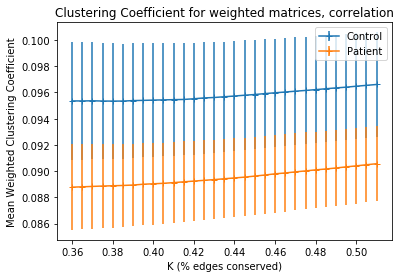

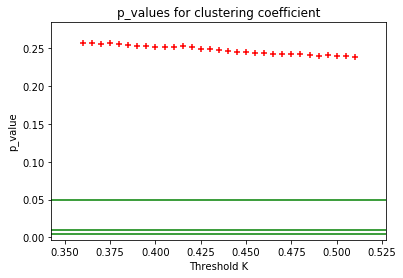

In [245]:
general_clustering_coef(pc_cor_K_list, pp_cor_K_list, K_list, "correlation", True, power_path)

#### Power Atlas, Tangent, Weighted Matrices

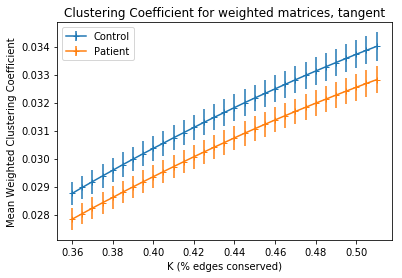

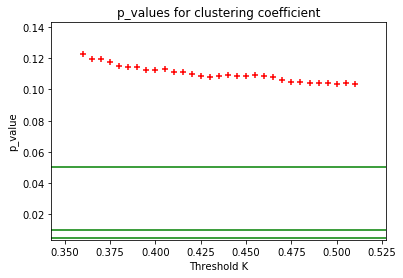

In [246]:
general_clustering_coef(pc_tan_K_list, pp_tan_K_list, K_list, "tangent", True, power_path)

#### DictLearn - Tangent, Binary
Better for $K \le 0.44$.

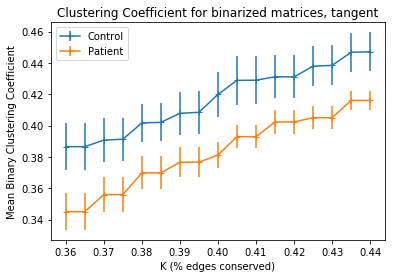

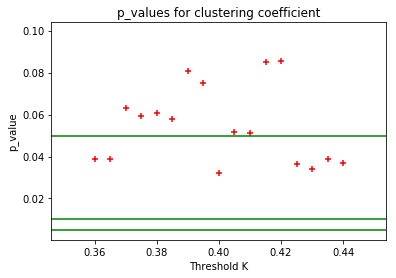

In [249]:
general_clustering_coef(dc_tan_K_list_bin[:17], dp_tan_K_list_bin[:17], K_list[:17], "tangent", False, dict_path)

#### DictLearn - Tangent, Weighted
Better for $K \le 0.45$.

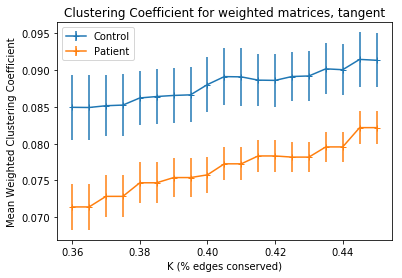

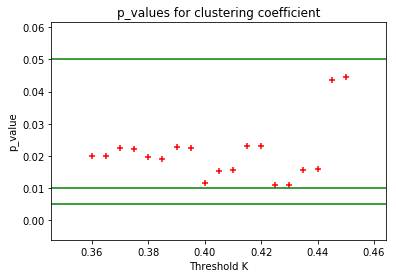

In [250]:
general_clustering_coef(dc_tan_K_list[:19], dp_tan_K_list[:19], K_list[:19], "tangent", True, dict_path)

## 2) Charpath and Efficiency

Here will only be plotted interesting graphs (ie with significant difference between control and patient). <br>
However, all atlas and connectivity measure have been tested: <br>
- Harvard-Oxford:
    - correlation: graphs don't seem connected (however, small difference in efficiency).
    - tangent weighted: difference in graphs, but high p-value.
    - tangent binary: no difference
   
    
- Power:
    - weighted (tangent or correlation): difference in graphs, but p-value $\approx 0.1$.
    - binary (tangent or correlation): no significant difference.
    
    
- DictLearn (depends much of the threshold):
    - correlation: patient graphs don't seem connected, so not relevant. <font color="orange">(So, patient graphs less connected than control ones?)</font>
    - tangent (weighted or binary): graph seem different, but p-value isn't good
    
    
    
**Observed differences: patients tend to have longer characteristic path and lower efficiency than controls.** <font color="orange">Is it coherent with previous works? REF</font>

#### Harvard - Tangent, weighted

c:\program files (x86)\pyzo2015a\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in reciprocal


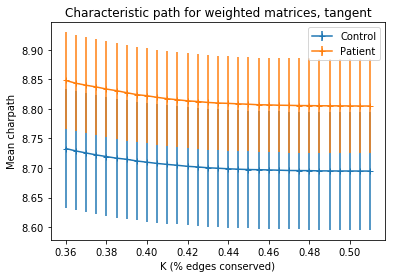

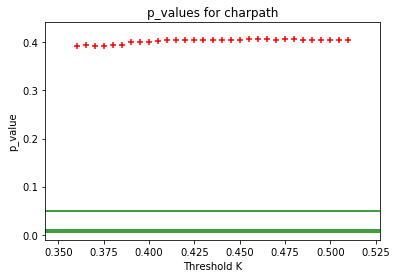

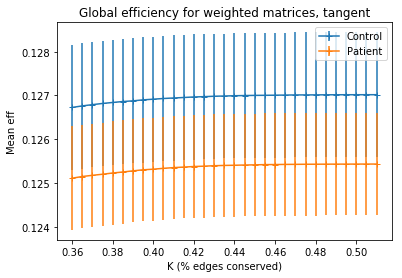

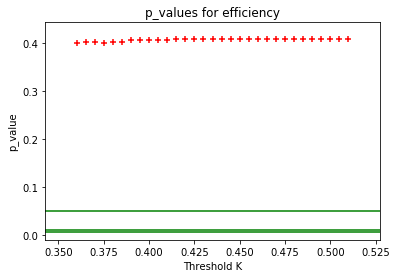

In [260]:
general_charpath_efficiency(hc_tan_K_list, hp_tan_K_list, K_list, "tangent", True, harvard_path)

#### Power - Correlation, weighted

c:\program files (x86)\pyzo2015a\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in reciprocal


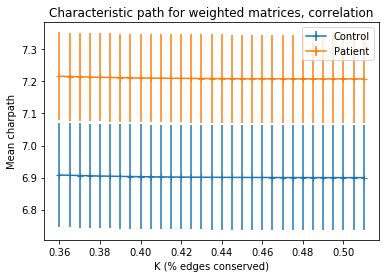

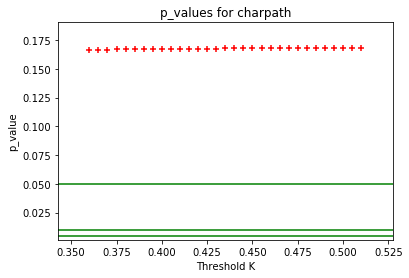

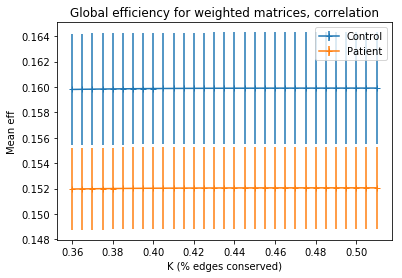

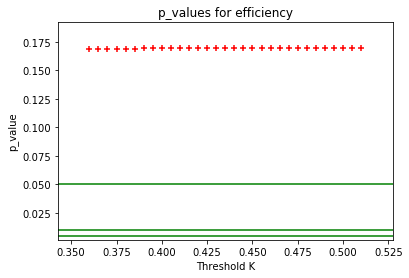

In [285]:
general_charpath_efficiency(pc_cor_K_list, pp_cor_K_list, K_list, "correlation", True, power_path)

#### Power - Tangent, weighted

c:\program files (x86)\pyzo2015a\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in reciprocal


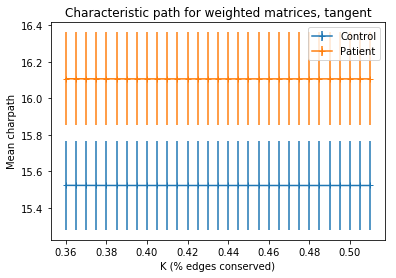

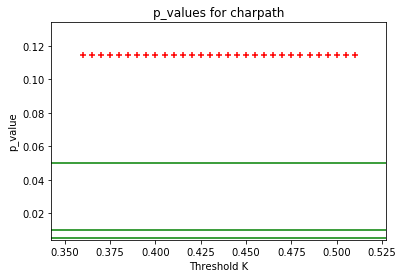

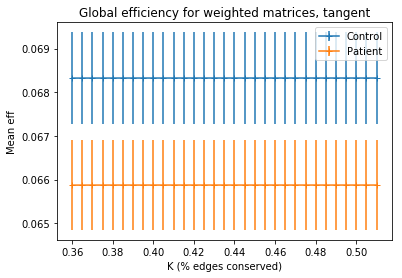

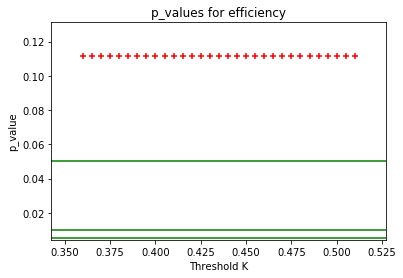

In [262]:
general_charpath_efficiency(pc_tan_K_list, pp_tan_K_list, K_list, "tangent", True, power_path)

#### Dictionary Learning - Tangent, Weighted

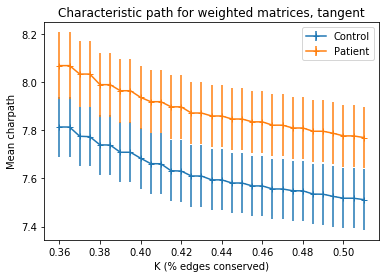

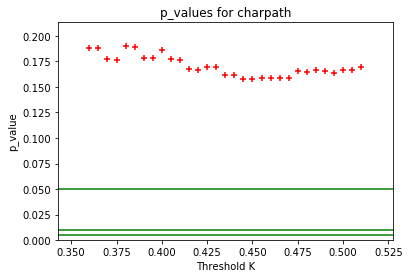

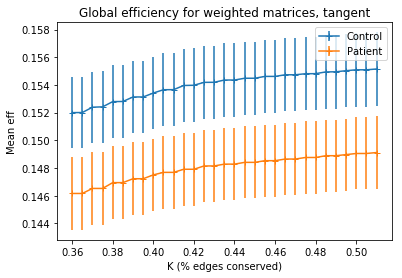

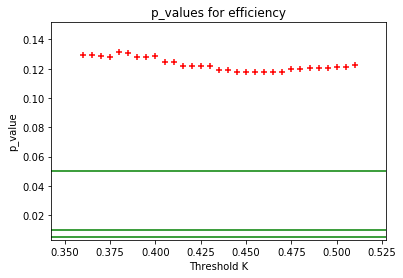

In [286]:
general_charpath_efficiency(dc_tan_K_list, dp_tan_K_list, K_list, "tangent", True, dict_path)

#### DictLearning - Tangent, binary

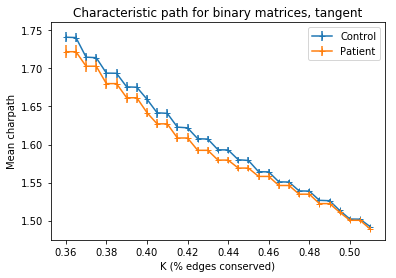

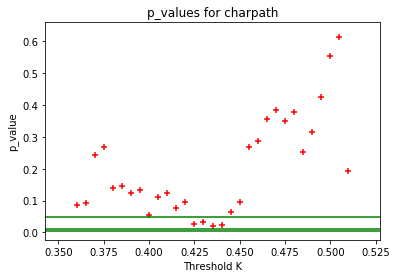

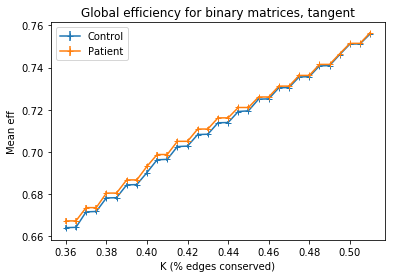

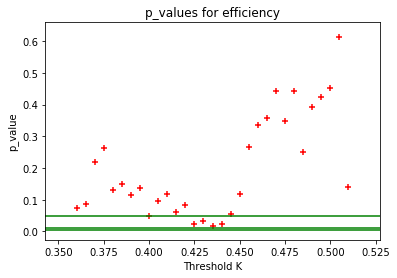

In [259]:
general_charpath_efficiency(dc_tan_K_list_bin, dp_tan_K_list_bin, K_list, "tangent", False, dict_path)

## 3) Degree Distribution

There doesn't really seem to be a significant difference in degree distributions. <br>
However, for Power atlas (correlation, weighted), patients seem to have more "medium-degree" node and less "high-degree" nodes.

#### Harvard-Oxford

In [312]:
#Harvard - Correlation, weighted
general_degree_dist(hc_cor_K_list, hp_cor_K_list, K_list, harvard_path+"Degree dist correlation weighted\\")

#Harvard - Correlation, binary
general_degree_dist(hc_cor_K_list_bin, hp_cor_K_list_bin, K_list, harvard_path+"Degree dist correlation binary\\")

In [313]:
#Harvard - Tangent, weighted
general_degree_dist(hc_tan_K_list, hp_tan_K_list, K_list, harvard_path+"Degree dist tangent weighted\\")

#Harvard - Tangent, binary
general_degree_dist(hc_tan_K_list_bin, hp_tan_K_list_bin, K_list, harvard_path+"Degree dist tangent binary\\")

#### Power Atlas

In [320]:
#Power - Correlation, weighted
general_degree_dist(pc_cor_K_list, pp_cor_K_list, K_list, power_path+"Degree dist correlation weighted\\")

#Power - Correlation, binarp
general_degree_dist(pc_cor_K_list_bin, pp_cor_K_list_bin, K_list, power_path+"Degree dist correlation binary\\")

In [317]:
#Power - Tangent, weighted
general_degree_dist(pc_tan_K_list, pp_tan_K_list, K_list, power_path+"Degree dist tangent weighted\\")

#Power - Tangent, binary
general_degree_dist(pc_tan_K_list_bin, pp_tan_K_list_bin, K_list, power_path+"Degree dist tangent binary\\")

#### Dictionnary Learning

In [319]:
#Dict - Correlation, weighted
general_degree_dist(dc_cor_K_list, dp_cor_K_list, K_list, dict_path+"Degree dist correlation weighted\\")

#Dict - Correlation, binary
general_degree_dist(dc_cor_K_list_bin, dp_cor_K_list_bin, K_list, dict_path+"Degree dist correlation binary\\")

In [318]:
#Dict - Tangent, weighted
general_degree_dist(dc_tan_K_list, dp_tan_K_list, K_list, dict_path+"Degree dist tangent weighted\\")

#Dict - Tangent, binary
general_degree_dist(dc_tan_K_list_bin, dp_tan_K_list_bin, K_list, dict_path+"Degree dist tangent binary\\")

## 4) Degree by Clustering coefficient

- Harvard Oxford:
    - No difference.
    
    
- Power Atlas:
    - Binary (tangent and correlation): no difference.
    - Weighted (tangent and correlation): the two distributions are differents.
    
    
- Dict Learning:
    - No difference (not enought nodes)

#### Power Atlas - Correlation, weighted

In [ ]:
general_degree_clustering(pc_cor_K_list, pp_cor_K_list, K_list, True, 
                          power_path+"Deg_Clu_Correlation_Wei\\")

#### Power Atlas - Tangent, Weighted

In [359]:
general_degree_clustering(pc_tan_K_list, pp_tan_K_list, K_list, True, 
                          power_path+"Deg_Clu_Tangent_Wei\\")

##  5) Small-World Coefficient

# VI - Classification

Different classification methods were used; however, the reduced number of subjects, as well as the huge size of data (especially for Power Atlas) did not allow these methods to work efficiently.

Dimension reduction: we tried to reduce the dimensions (PCA), but it wasn't efficient. Keeping only some nodes looses information about the graph stucture.

Artificially increasing the dataset size could be a solution. (To try in the future.)

## SVC

### On matrices

### On clustering coefficient

### On charpath

### On Small-World coefficient

## Dendrograms

Dendrogramms were used in order to try to classify matrices with no supervision. Here are only presented examples and ideal dendrograms; however no dendrograms on real datas gave satisfying result.

The methods in this article <font color="orange"> REF </font> was used to try and get a good dendrogram, but it was uneffective with Power Atlas.

### Ideal Dendrogram
This is a dendrogram computed with distances on meta-data.

In [274]:
def d_status (i,j):
    d = 0
    if (i < n_control) ^ (j < n_control):
        d = 1
    return(d)

def d_age (i,j):
    a_i = list_pheno[i]["Age"]
    a_j = list_pheno[j]["Age"]
    d = abs(a_i - a_j) # Can give important difference
    return(d)

def d_gender (i,j):
    g_i = list_pheno[i]["Gender"]
    g_j = list_pheno[j]["Gender"]
    if g_i == g_j:
        return 0
    else:
        return 1
    
# We could use a similar distance for handedness 
# (not useful with matched patient since they are all right-handed).

In [281]:
d_attribute = np.zeros((n_subject, n_subject))
for i in range(n_subject):
    for j in range(i):
        d = 10*d_status(i,j) + d_age(i,j) + 0.3*d_gender(i,j)
        d_attribute[i][j] = d
        d_attribute[j][i] = d

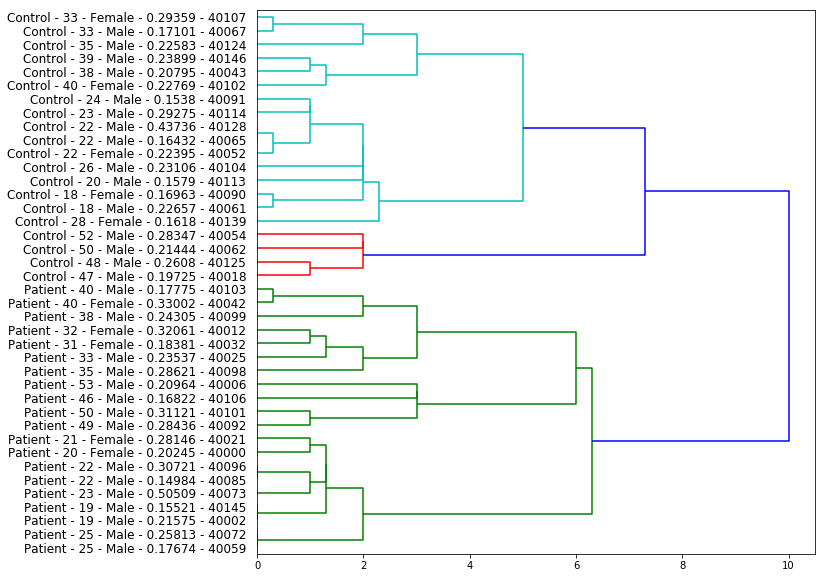

In [282]:
l = [ "{0} - {1} - {2} - {3} - {4} ".format(d["Status"], d["Age"], d["Gender"], d["FD"],
                                            d["ID"]) for d in list_pheno]

dendrogram(d_attribute, l) 

### Metric Learning

<font color="orange">The End :)</font>